In [14]:
# --- SETUP & LOAD ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from pathlib import Path
plt.rcParams["figure.figsize"] = (8,5)

pairs_path = Path("../data/processed/pairs_snapshot_SPY.parquet")
if not pairs_path.exists():
    raise FileNotFoundError(f"Missing file: {pairs_path}  (Run 01 notebook.)")

pairs = pd.read_parquet(pairs_path, engine="pyarrow").copy()
print(f"Loaded {len(pairs)} rows from:", pairs_path)
pairs.head(3)


Loaded 564 rows from: ..\data\processed\pairs_snapshot_SPY.parquet


,contractSymbol_c,lastTradeDate_c,strike,last_c,bid_c,ask_c,change_c,percentChange_c,volume_c,oi_c,...,inTheMoney_p,contractSize_p,currency_p,option_type_p,mid_p,spread_p,S,trade_date,T_days,T
0,SPY251016C00550000,2025-10-08 14:21:26+00:00,550.0,122.17,111.06,113.69,0.0,0.0,NaN,NaN,...,False,REGULAR,USD,put,0.035,0.01,663.039978,2025-10-13,3,0.008219
1,SPY251016C00570000,2025-10-08 14:21:26+00:00,570.0,102.22,91.18,93.73,0.0,0.0,NaN,NaN,...,False,REGULAR,USD,put,0.055,0.01,663.039978,2025-10-13,3,0.008219
2,SPY251016C00575000,2025-10-08 14:29:03+00:00,575.0,97.35,85.96,88.73,0.0,0.0,NaN,2.0,...,False,REGULAR,USD,put,0.055,0.01,663.039978,2025-10-13,3,0.008219


In [15]:
print("Unique expiries:", pairs["expiry"].nunique())
print("Strike range:", float(pairs["strike"].min()), "→", float(pairs["strike"].max()))
pairs[["expiry","strike","mid_c","mid_p","spread_c","spread_p","S","T"]].sample(5, random_state=1)


Unique expiries: 7
Strike range: 325.0 → 850.0


,expiry,strike,mid_c,mid_p,spread_c,spread_p,S,T
47,2025-10-16,650.0,14.085,1.415,0.13,0.01,663.039978,0.008219
246,2025-10-17,720.0,0.005,57.910,0.01,2.76,663.039978,0.010959
509,2025-10-24,645.0,21.520,2.955,0.12,0.03,663.039978,0.030137
458,2025-10-24,540.0,123.325,0.155,2.35,0.01,663.039978,0.030137
358,2025-10-22,605.0,58.490,0.415,0.18,0.01,663.039978,0.024658


In [16]:
# --- DIVIDEND YIELD q (robust) ---
# Use S from your dataset to avoid an extra download; fall back to yfinance if needed.
S_now = float(pairs["S"].median())
if not np.isfinite(S_now) or S_now <= 0:
    spot_df = yf.download("SPY", period="5d", auto_adjust=True, progress=False)
    S_now = float(spot_df["Close"].iloc[-1])

spy = yf.Ticker("SPY")

# TTM cash dividends → yield
try:
    divs = spy.dividends  # pandas Series of cash amounts
    if divs is not None and len(divs) > 0:
        last_12m = divs[divs.index >= (pd.Timestamp.today() - pd.Timedelta(days=365))]
        div_ttm = float(last_12m.sum())
        div_yield = div_ttm / S_now if S_now > 0 else np.nan
    else:
        div_ttm, div_yield = 0.0, np.nan
except Exception:
    div_ttm, div_yield = 0.0, np.nan

# Fallback to info['dividendYield'] but guard for scale (% vs decimal)
if (not np.isfinite(div_yield)) or (div_yield <= 0):
    alt = spy.info.get("dividendYield", None)
    if alt is not None and np.isfinite(alt):
        div_yield = float(alt)/100.0 if float(alt) > 1.0 else float(alt)
    else:
        div_yield = 0.015  # final fallback ~1.5%

q = np.log1p(div_yield)  # continuous

print(f"S_now={S_now:.4f} | TTM div=${div_ttm:.4f} | div_yield={div_yield:.4%} | q={q:.6f}")


S_now=663.0400 | TTM div=$0.0000 | div_yield=1.0900% | q=0.010841


In [17]:
# --- TERM-STRUCTURE r(T) ---
def last_mean_pct(symbol, days=10):
    try:
        h = yf.Ticker(symbol).history(period=f"{days}d")["Close"].dropna()
        if len(h) == 0:
            return np.nan
        return float(h.tail(min(5, len(h))).mean())/100.0  # % → decimal
    except Exception:
        return np.nan

r_irx = last_mean_pct("^IRX")   # ~13w (~0.25y)
r_fvx = last_mean_pct("^FVX")   # 5y
r_tnx = last_mean_pct("^TNX")   # 10y

# Reasonable fallbacks if missing
for name, val in (("IRX", r_irx), ("FVX", r_fvx), ("TNX", r_tnx)):
    if not np.isfinite(val) or val <= 0:
        print(f"Warning: {name} missing; using fallback 5%")
        if name == "IRX": r_irx = 0.05
        if name == "FVX": r_fvx = 0.05
        if name == "TNX": r_tnx = 0.05

T = pairs["T"].values
r_ann = np.select(
    [
        T <= 0.33,                 # up to ~4 months → bills
        (T > 0.33) & (T <= 2.0),   # up to ~2y → use 5y as proxy
        T > 2.0                    # long-dated → 10y
    ],
    [r_irx, r_fvx, r_tnx],
    default=r_irx
)

pairs["r_ann"] = r_ann
pairs["r_cont"] = np.log1p(pairs["r_ann"])  # continuous r(T)
pairs[["T","r_ann","r_cont"]].head(3)


,T,r_ann,r_cont
0,0.008219,0.03849,0.037768
1,0.008219,0.03849,0.037768
2,0.008219,0.03849,0.037768


In [18]:
# --- PUT–CALL PARITY with q & r(T) ---
pairs = pairs.copy()
pairs["cp_mid"]  = pairs["mid_c"] - pairs["mid_p"]
pairs["theo_cp"] = pairs["S"]*np.exp(-q*pairs["T"]) - pairs["strike"]*np.exp(-pairs["r_cont"]*pairs["T"])
pairs["parity_diff"] = pairs["cp_mid"] - pairs["theo_cp"]
pairs["parity_pct"]  = 100 * pairs["parity_diff"] / pairs["strike"]

pairs[["expiry","strike","mid_c","mid_p","cp_mid","theo_cp","parity_diff","parity_pct"]].head(10)


,expiry,strike,mid_c,mid_p,cp_mid,theo_cp,parity_diff,parity_pct
0,2025-10-16,550.0,112.375,0.035,112.340,113.151605,-0.811605,-0.147565
1,2025-10-16,570.0,92.455,0.055,92.400,93.157813,-0.757813,-0.132950
2,2025-10-16,575.0,87.345,0.055,87.290,88.159365,-0.869365,-0.151194
3,2025-10-16,601.0,61.575,0.115,61.460,62.167434,-0.707434,-0.117710
4,2025-10-16,602.0,60.545,0.120,60.425,61.167745,-0.742745,-0.123380
5,2025-10-16,603.0,59.435,0.125,59.310,60.168055,-0.858055,-0.142298
6,2025-10-16,604.0,58.390,0.125,58.265,59.168365,-0.903365,-0.149564
7,2025-10-16,605.0,57.540,0.125,57.415,58.168676,-0.753676,-0.124575
8,2025-10-16,606.0,56.535,0.125,56.410,57.168986,-0.758986,-0.125245
9,2025-10-16,607.0,55.560,0.135,55.425,56.169296,-0.744296,-0.122619


In [19]:
# --- cp-space no-arb band (from bid/ask) ---
# Approximating bid/ask from mid±spread/2 (Yahoo gives bid/ask; we derived spreads already)
C_bid = pairs["mid_c"] - pairs["spread_c"]/2
C_ask = pairs["mid_c"] + pairs["spread_c"]/2
P_bid = pairs["mid_p"] - pairs["spread_p"]/2
P_ask = pairs["mid_p"] + pairs["spread_p"]/2

pairs["cp_low"]  = C_bid - P_ask   # best you can lock (sell call@bid, buy put@ask)
pairs["cp_high"] = C_ask - P_bid   # worst you must pay (buy call@ask, sell put@bid)

# flag if theo_cp lies outside the band (ignores micro-rounding)
pairs["cp_violation"] = np.where(pairs["theo_cp"] < pairs["cp_low"], -1,    # theoretical too low: BuySyn_SellAct
                          np.where(pairs["theo_cp"] > pairs["cp_high"], 1,   # theoretical too high: SellSyn_BuyAct
                                   0))
pairs["cp_violation"].value_counts()


cp_violation
 1    372
 0    190
-1      2
Name: count, dtype: int64

In [20]:
# --- Forward mapping (equivalent to cp) ---
pairs["F_theo"]    = pairs["S"]*np.exp((pairs["r_cont"] - q)*pairs["T"])

# Synthetic forward prices with costs:
pairs["F_syn_mid"]  = (pairs["cp_mid"] * np.exp(pairs["r_cont"]*pairs["T"])) + pairs["strike"]
pairs["F_syn_sell"] = (pairs["cp_low"] * np.exp(pairs["r_cont"]*pairs["T"])) + pairs["strike"]
pairs["F_syn_buy"]  = (pairs["cp_high"]* np.exp(pairs["r_cont"]*pairs["T"])) + pairs["strike"]

# Edges vs actual forward
pairs["edge_mid"]  = pairs["F_syn_mid"]  - pairs["F_theo"]
pairs["edge_sell"] = pairs["F_syn_sell"] - pairs["F_theo"]   # >0: synthetic fwd rich (sell syn, buy actual)
pairs["edge_buy"]  = pairs["F_syn_buy"]  - pairs["F_theo"]   # <0: synthetic fwd cheap (buy syn, sell actual)

pairs[["expiry","strike","F_theo","F_syn_sell","F_syn_buy","edge_sell","edge_buy"]].head(10)


,expiry,strike,F_theo,F_syn_sell,F_syn_buy,edge_sell,edge_buy
0,2025-10-16,550.0,663.186735,661.054468,663.695288,-2.132267,0.508553
1,2025-10-16,570.0,663.186735,661.148290,663.709085,-2.038445,0.522349
2,2025-10-16,575.0,663.186735,660.926669,663.707532,-2.260066,0.520797
3,2025-10-16,601.0,663.186735,661.238696,663.719466,-1.948039,0.532731
4,2025-10-16,602.0,663.186735,661.158361,663.729159,-2.028374,0.542424
5,2025-10-16,603.0,663.186735,660.927979,663.728849,-2.258756,0.542113
6,2025-10-16,604.0,663.186735,660.847644,663.718535,-2.339091,0.531800
7,2025-10-16,605.0,663.186735,661.127420,663.738231,-2.059315,0.551495
8,2025-10-16,606.0,663.186735,661.127110,663.727917,-2.059625,0.541182
9,2025-10-16,607.0,663.186735,661.146806,663.737610,-2.039930,0.550874


In [23]:
# --- CONSISTENCY CHECK: cp-band vs forward-band signs ---
# If theo_cp > cp_high  -> synthetic fwd (buy) should be expensive -> edge_buy > 0
# If theo_cp < cp_low   -> synthetic fwd (buy) should be cheap     -> edge_buy < 0

chk = pd.DataFrame({
    "theo_cp_minus_high": pairs["theo_cp"] - pairs["cp_high"],
    "theo_cp_minus_low":  pairs["theo_cp"] - pairs["cp_low"],
    "edge_buy":           pairs["edge_buy"],
    "edge_sell":          pairs["edge_sell"]
})

ok_high = np.sign(chk["theo_cp_minus_high"]) == np.sign(chk["edge_buy"])   # both >0 or both <0
ok_low  = np.sign(-chk["theo_cp_minus_low"]) == np.sign(-chk["edge_buy"])


In [26]:
eps = 1e-9

above = (pairs["theo_cp"] - pairs["cp_high"]) >  eps        # theo_cp > cp_high
below = (pairs["theo_cp"] - pairs["cp_low"])  < -eps        # theo_cp < cp_low
inside = ~(above | below)

# Expected signs
ok_above = (pairs.loc[above, "edge_buy"]  < -eps).all()     # must be negative
ok_below = (pairs.loc[below, "edge_sell"] >  eps).all()     # must be positive
ok_inside = (
    (pairs.loc[inside, "edge_sell"] <= eps).all() and
    (pairs.loc[inside, "edge_buy"]  >= -eps).all()
)

print("Rows: above:", above.sum(), "| below:", below.sum(), "| inside:", inside.sum())
print("Consistency: above→edge_buy<0:", ok_above,
      "| below→edge_sell>0:", ok_below,
      "| inside→no-trade signs:", ok_inside)

# If anything fails, show 5 examples of the first failing bucket
def show_examples(mask, cols, n=5, title=""):
    if mask.any():
        print("\nExamples —", title)
        display(pairs.loc[mask, cols].head(n))

cols = ["expiry","strike","theo_cp","cp_low","cp_high","F_theo","F_syn_sell","F_syn_buy","edge_sell","edge_buy"]

if not ok_above:  show_examples(above & ~(pairs["edge_buy"] < -eps), cols, title="ABOVE but edge_buy not < 0")
if not ok_below:  show_examples(below & ~(pairs["edge_sell"] >  eps), cols, title="BELOW but edge_sell not > 0")
if not ok_inside: show_examples(inside & ~((pairs["edge_sell"] <= eps) & (pairs["edge_buy"] >= -eps)),
                                cols, title="INSIDE but signs not no-trade")


Rows: above: 372 | below: 2 | inside: 190
Consistency: above→edge_buy<0: True | below→edge_sell>0: True | inside→no-trade signs: True


In [27]:
# --- Signals & PnL (discounted to present) ---
mult = 100.0

# Signals from forward band (consistent with cp_violation)
pairs["signal"] = np.where(pairs["edge_sell"] > 0, "SellSyn_BuyAct",
                    np.where(pairs["edge_buy"]  < 0, "BuySyn_SellAct", "NoTrade"))

# Discount edges to t=0 for comparability
disc = np.exp(pairs["r_cont"]*pairs["T"])
pairs["edge_sell_disc$"] = (pairs["edge_sell"]/disc) * mult
pairs["edge_buy_disc$"]  = (pairs["edge_buy"] /disc) * mult

pairs["edge_disc$"] = 0.0
pairs.loc[pairs["signal"]=="SellSyn_BuyAct", "edge_disc$"] = pairs["edge_sell_disc$"]
pairs.loc[pairs["signal"]=="BuySyn_SellAct", "edge_disc$"] = -pairs["edge_buy_disc$"]

# Liquidity quality cut (tighten as you like)
liq_mask = (pairs["spread_c"]<0.5) & (pairs["spread_p"]<0.5) & (pairs["mid_c"]>0) & (pairs["mid_p"]>0)
signal_df = pairs[liq_mask].copy()

print("Total pairs:", len(pairs), "| Liquid pairs:", len(signal_df))
signal_df["signal"].value_counts()


Total pairs: 564 | Liquid pairs: 411


signal
BuySyn_SellAct    369
NoTrade            42
Name: count, dtype: int64

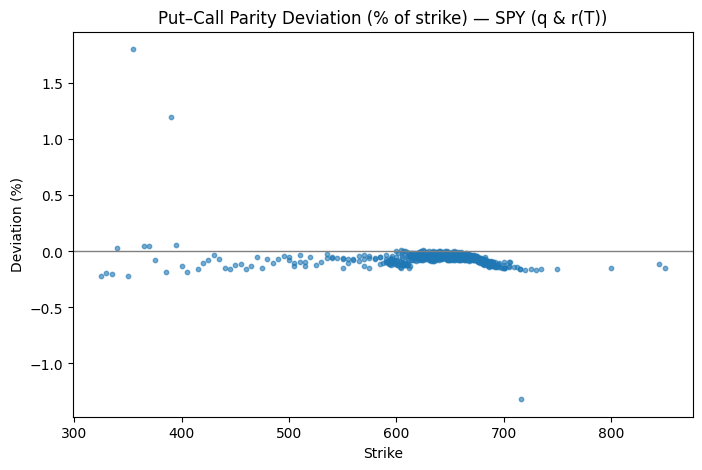

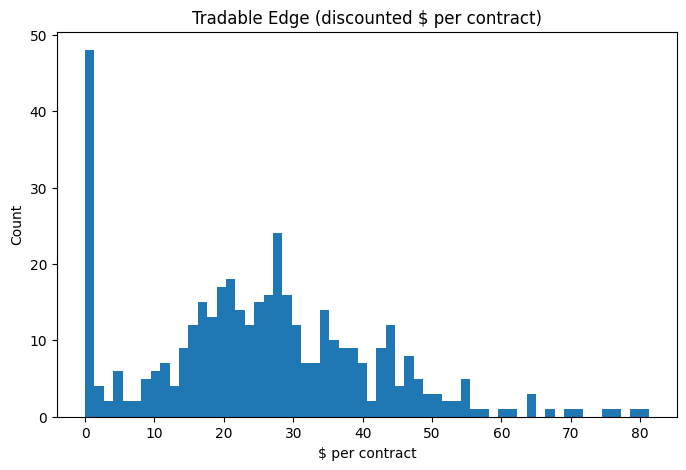

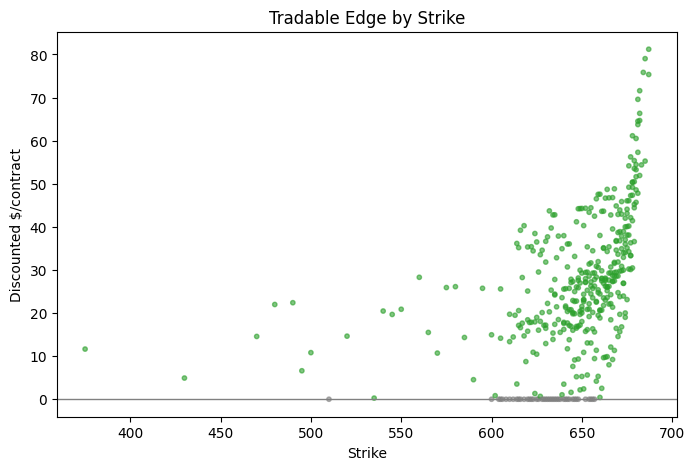

edge_disc$                                             abs_edge  \
                count       mean     median        max        min    count   
expiry                                                                       
2025-10-16         60  39.932515  40.283170  61.133286  20.109060       60   
2025-10-17         96  22.982659  20.518349  66.342636   0.000000       96   
2025-10-20         46  33.636842  29.349654  71.594211  17.204844       46   
2025-10-21         45  31.752909  27.939095  75.842215   7.615186       45   
2025-10-22         43  29.026565  26.245342  81.223984   9.431507       43   
2025-10-23         45  24.520085  20.943992  75.356844   3.496116       45   
2025-10-24         76   7.513613   0.000000  55.261515   0.000000       76   

                                                        
                 mean     median        max        min  
expiry                                                  
2025-10-16  39.932515  40.283170  61.133286  20.109060  
2025-10-17  22.982659  20.518349  66.342636   0.000000  
2025-10-20  33.636842  29.349654  71.594211  17.204844  
2025-10-21  31.752909  27.939095  75.842215   7.615186  
2025-10-22  29.026565  26.245342  81.223984   9.431507  
2025-10-23  24.520085  20.943992  75.356844   3.496116  
2025-10-24   7.513613   0.000000  55.261515   0.000000

In [28]:
# Parity deviation
plt.scatter(pairs["strike"], pairs["parity_pct"], s=10, alpha=0.6)
plt.axhline(0, color="gray", lw=1)
plt.title("Put–Call Parity Deviation (% of strike) — SPY (q & r(T))")
plt.xlabel("Strike"); plt.ylabel("Deviation (%)"); plt.show()

# Edge histogram
plt.hist(signal_df["edge_disc$"], bins=60)
plt.title("Tradable Edge (discounted $ per contract)")
plt.xlabel("$ per contract"); plt.ylabel("Count"); plt.show()

# Edge by strike
colors = signal_df["signal"].map({"SellSyn_BuyAct":"tab:red","BuySyn_SellAct":"tab:green","NoTrade":"tab:gray"})
plt.scatter(signal_df["strike"], signal_df["edge_disc$"], s=10, alpha=0.6, c=colors)
plt.axhline(0, color="gray", lw=1)
plt.title("Tradable Edge by Strike")
plt.xlabel("Strike"); plt.ylabel("Discounted $/contract"); plt.show()

# Summary table by expiry
summary = (signal_df
           .assign(abs_edge=lambda d: d["edge_disc$"].abs())
           .groupby("expiry")[["edge_disc$","abs_edge"]]
           .agg(["count","mean","median","max","min"]))
summary


In [29]:
# --- SUMMARY FOR REPORT ---
eps = 1e-9
total = len(pairs)
inside = ((pairs["theo_cp"] - pairs["cp_low"] >= -eps) & (pairs["theo_cp"] - pairs["cp_high"] <= eps)).sum()
above  = (pairs["theo_cp"] - pairs["cp_high"] >  eps).sum()
below  = (pairs["theo_cp"] - pairs["cp_low"]  < -eps).sum()

within_pct = 100*inside/total
mean_dev  = pairs["parity_pct"].mean()
mad_dev   = pairs["parity_pct"].abs().median()
p95_dev   = pairs["parity_pct"].abs().quantile(0.95)

print(f"Pairs total: {total} | inside band: {inside} ({within_pct:.1f}%) | above: {above} | below: {below}")
print(f"Parity deviation: mean={mean_dev:.3f}% | median(|dev|)={mad_dev:.3f}% | 95th(|dev|)={p95_dev:.3f}%")

# tradable edges after liquidity
liq_mask = (pairs["spread_c"]<0.5) & (pairs["spread_p"]<0.5) & (pairs["mid_c"]>0) & (pairs["mid_p"]>0)
sd = pairs[liq_mask].copy()
mean_edge = sd["edge_disc$"].mean()
p95_edge  = sd["edge_disc$"].abs().quantile(0.95)
print(f"After costs & liquidity: mean discounted edge = ${mean_edge:.2f} /contract | 95th(|edge|) = ${p95_edge:.2f}")


Pairs total: 564 | inside band: 190 (33.7%) | above: 372 | below: 2
Parity deviation: mean=-0.062% | median(|dev|)=0.058% | 95th(|dev|)=0.145%
After costs & liquidity: mean discounted edge = $25.55 /contract | 95th(|edge|) = $52.59


In [30]:
out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
res_path = out_dir / "parity_results_SPY.parquet"
csv_path = out_dir / "parity_results_SPY.csv"

signal_df.to_parquet(res_path, index=False, engine="pyarrow")
(signal_df[["expiry","strike","signal","edge_disc$","F_theo","F_syn_sell","F_syn_buy"]]
 .sort_values(["expiry","strike"])
 .to_csv(csv_path, index=False))

print("Saved:")
print(" -", res_path)
print(" -", csv_path)


Saved:
 - ..\data\processed\parity_results_SPY.parquet
 - ..\data\processed\parity_results_SPY.csv


In [31]:
cols = ["expiry","strike","signal","edge_disc$","mid_c","mid_p","spread_c","spread_p","S","T"]
top = (signal_df[cols]
       .sort_values("edge_disc$", ascending=False)
       .head(15))
top


,expiry,strike,signal,edge_disc$,mid_c,mid_p,spread_c,spread_p,S,T
400,2025-10-22,687.0,BuySyn_SellAct,81.223984,0.115,24.525,0.01,0.19,663.039978,0.024658
399,2025-10-22,685.0,BuySyn_SellAct,79.037819,0.175,22.560,0.01,0.18,663.039978,0.024658
354,2025-10-21,684.0,BuySyn_SellAct,75.842215,0.145,21.545,0.01,0.17,663.039978,0.021918
452,2025-10-23,687.0,BuySyn_SellAct,75.356844,0.165,24.460,0.01,0.18,663.039978,0.027397
302,2025-10-20,682.0,BuySyn_SellAct,71.594211,0.170,19.590,0.02,0.18,663.039978,0.019178
352,2025-10-21,681.0,BuySyn_SellAct,69.593982,0.315,18.660,0.01,0.18,663.039978,0.021918
229,2025-10-17,682.0,BuySyn_SellAct,66.342636,0.075,19.585,0.01,0.17,663.039978,0.010959
353,2025-10-21,682.0,BuySyn_SellAct,64.676727,0.235,19.520,0.01,0.16,663.039978,0.021918
301,2025-10-20,681.0,BuySyn_SellAct,64.521806,0.215,18.560,0.01,0.18,663.039978,0.019178
451,2025-10-23,681.0,BuySyn_SellAct,63.736325,0.570,18.755,0.02,0.17,663.039978,0.027397
